In [6]:
# imports
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from contextlib import redirect_stdout
import os
import h5py
import json
import gc
import io
import joblib
from sklearn.calibration import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image

from google.cloud import vision  

## obj detector

In [10]:
def localize_objects_file(content): #file
    objectBox = []
    box = []
    temp = []
    
    client = vision.ImageAnnotatorClient()
    image_stream = io.BytesIO(content)
    with Image.open(image_stream) as img:
        width, height = img.size    
    image = vision.Image(content=content)
    objects = client.object_localization(image=image).localized_object_annotations

    for object_ in objects:
        for vertex in object_.bounding_poly.normalized_vertices:
            pixel_x = int(vertex.x * width)
            pixel_y = int(vertex.y * height)
            temp.append(pixel_x)
            temp.append(pixel_y)
        box.append(temp[0])
        box.append(temp[1])
        box.append(temp[4])
        box.append(temp[5])
        temp = []
        object_info = {
            "name": object_.name,
            "confidence": object_.score,
            "box": box,
        }
        box = []
        objectBox.append(object_info)
        
    return objectBox
'ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ'
def obj_detection_file(content):
    # np_arr = np.frombuffer(content, np.uint8)
    # img = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
    objects = localize_objects_file(content)
    
    image_stream = io.BytesIO(content)
    with Image.open(image_stream) as img:
        width, height = img.size
        result = {
            'size': [width, height],
        }
        
        for i, obj in enumerate(objects):
            x1, y1, x2, y2 = obj['box']
            cropped_img = img.crop((x1, y1, x2, y2))
            obj['crop_img'] = cropped_img
        
    result['objects'] = objects
    return result
        

In [12]:
# path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\FlamakerConvertibleSectionalSofaCouchModernFabricUShapedLivingRoomFurnitureSetSeatSectionalSleeperSofawithDoubleChaiseMemoryFoamGrey.jpg'
# path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\FlamakerSectionalCouchSofaCouchforLivingRoomLShapedCouchwithReversibleChaiseFabricSmallCouchesforApartmentSmallSpacesDarkGrey.jpg'
parh = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\LivavegeConvertibleSleeperSectionalSofawithPullBedLShapedwStorageChaiseModernLinenFabricCornerSeatersCouchesforLivingRoomApartmentandSmallSpaceDarkGray.jpg'

with open(path, 'rb') as file:
    img_file = file.read()

ass = obj_detection_file(img_file)    
ass

{'size': [1500, 1500],
 'objects': [{'name': 'Couch',
   'confidence': 0.8216202259063721,
   'box': [81, 561, 1444, 1341],
   'crop_img': <PIL.Image.Image image mode=RGB size=1363x780>},
  {'name': 'Houseplant',
   'confidence': 0.7138032913208008,
   'box': [6, 460, 259, 974],
   'crop_img': <PIL.Image.Image image mode=RGB size=253x514>},
  {'name': 'Cabinetry',
   'confidence': 0.694159746170044,
   'box': [706, 312, 1200, 602],
   'crop_img': <PIL.Image.Image image mode=RGB size=494x290>},
  {'name': 'Table',
   'confidence': 0.5663098096847534,
   'box': [930, 1050, 1430, 1382],
   'crop_img': <PIL.Image.Image image mode=RGB size=500x332>}]}

## Classify

In [2]:
model = joblib.load('./svm_model.joblib')

# Load the LabelEncoder
le = joblib.load('./label_encoder.joblib')

In [3]:
model

RandomForestClassifier()

In [27]:
from torchvision import transforms
import numpy as np

def process_image_path(image_path):
    try:
        # Open the image file
        with Image.open(image_path) as img:
            # Resize and convert to RGB
            img = img.resize((64, 64)).convert('RGB')
            # Convert to numpy array and normalize
            img_array = np.asarray(img) / 255.0
            # # Transpose the array to have channels first
            # img_array = img_array.transpose((2, 0, 1))
            return img_array.reshape(1,-1)
    except IOError:
        print(f"Error in processing image: {image_path}")
        return None
def process_image_file(image_file):
    try:
        # Resize and convert to RGB
        image_file = image_file.resize((64, 64)).convert('RGB')
        # Convert to numpy array and normalize
        img_array = np.asarray(image_file) / 255.0
        # # Transpose the array to have channels first
        # img_array = img_array.transpose((2, 0, 1))
        return img_array.reshape(1,-1)
    except IOError:
        print(f"Error in processing image: {image_file}")
        return None

In [78]:
###  컨템포러리
path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\FlamakerConvertibleSectionalSofaCouchModernFabricUShapedLivingRoomFurnitureSetSeatSectionalSleeperSofawithDoubleChaiseMemoryFoamGrey.jpg'

###  모던
#path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\FlamakerSectionalCouchSofaCouchforLivingRoomLShapedCouchwithReversibleChaiseFabricSmallCouchesforApartmentSmallSpacesDarkGrey.jpg'
#path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\LivavegeConvertibleSleeperSectionalSofawithPullBedLShapedwStorageChaiseModernLinenFabricCornerSeatersCouchesforLivingRoomApartmentandSmallSpaceDarkGray.jpg'
#path = 'C:\\Users\\user\\Desktop\\BigF\\team5\\classify\\로맨틱3.png'

# 전체
big_processing = process_image_path(path)

# 크롭별
with open(path, 'rb') as file:
    img_file = file.read()

crop_img = obj_detection_file(img_file)    
crop_img['objects']

[{'name': 'Couch',
  'confidence': 0.8216202259063721,
  'box': [81, 561, 1444, 1341],
  'crop_img': <PIL.Image.Image image mode=RGB size=1363x780>},
 {'name': 'Houseplant',
  'confidence': 0.7138032913208008,
  'box': [6, 460, 259, 974],
  'crop_img': <PIL.Image.Image image mode=RGB size=253x514>},
 {'name': 'Cabinetry',
  'confidence': 0.694159746170044,
  'box': [706, 312, 1200, 602],
  'crop_img': <PIL.Image.Image image mode=RGB size=494x290>},
 {'name': 'Table',
  'confidence': 0.5663098096847534,
  'box': [930, 1050, 1430, 1382],
  'crop_img': <PIL.Image.Image image mode=RGB size=500x332>}]

In [ ]:
big_style = le.inverse_transform(big_predict)
print(big_style)

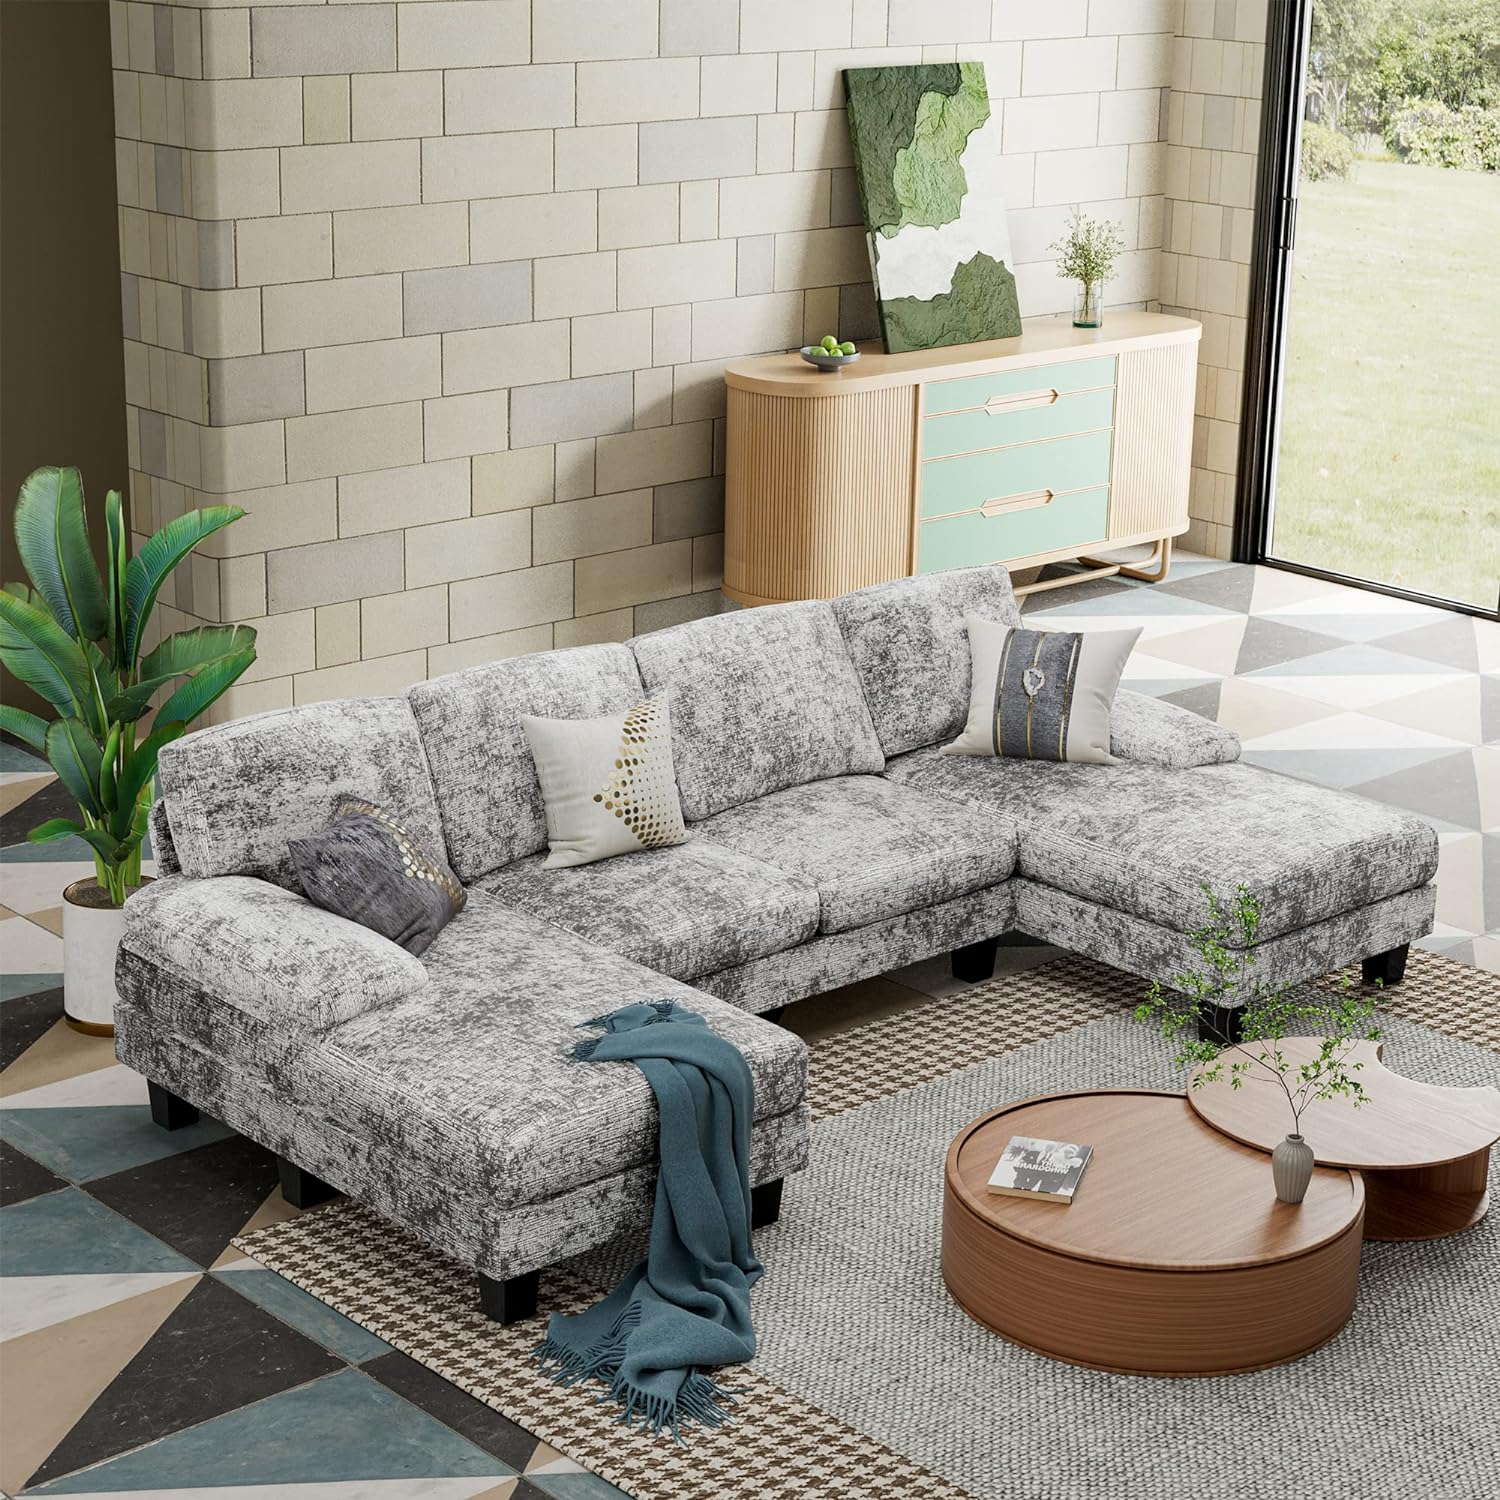

['Contemporary']


In [81]:
# 전체
with Image.open(path) as img:
    display(img)
big_predict = model.predict(big_processing)
big_style = le.inverse_transform(big_predict)
print(big_style)

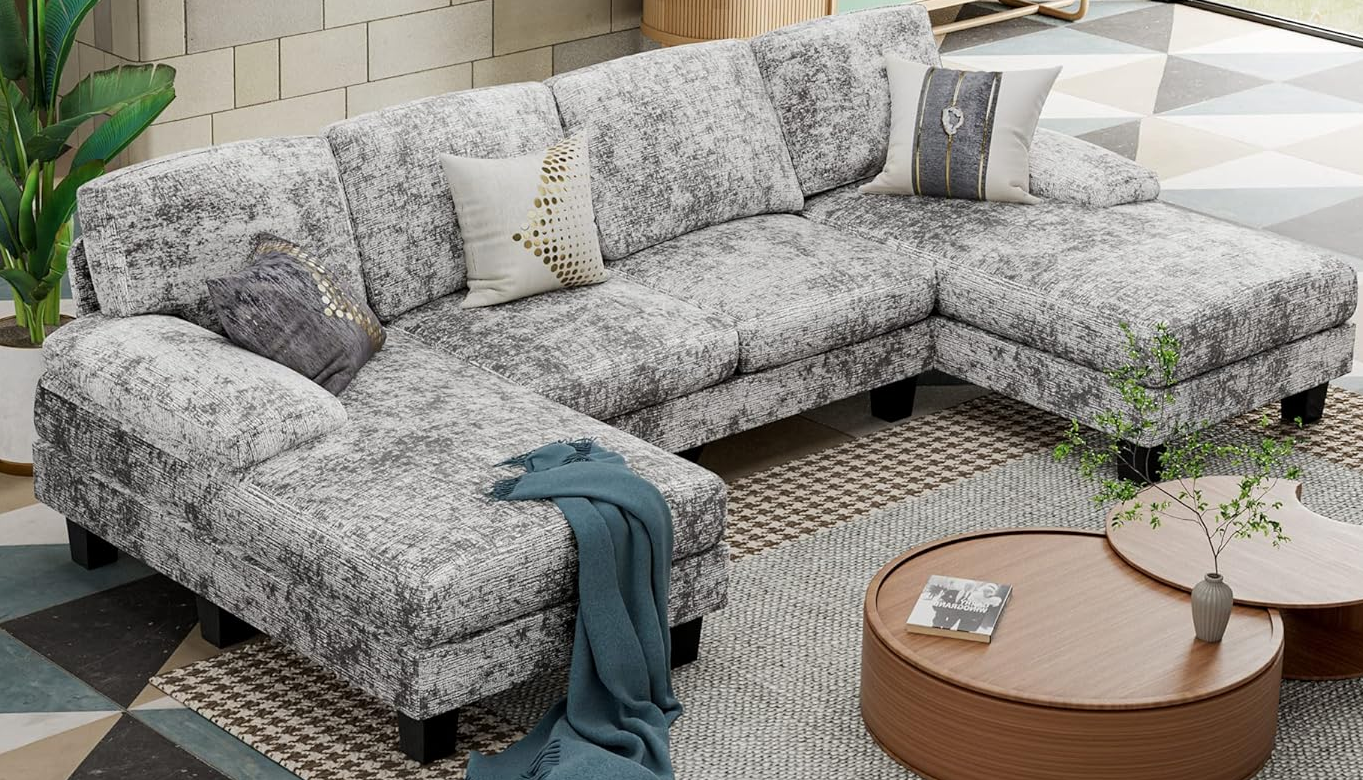

[[0.21568627 0.26666667 0.16470588 ... 0.57647059 0.56470588 0.5372549 ]]
['Modern']


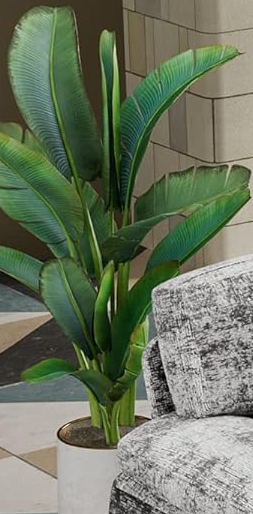

[[0.2745098  0.24313725 0.16862745 ... 0.7254902  0.72156863 0.71372549]]
['Modern']


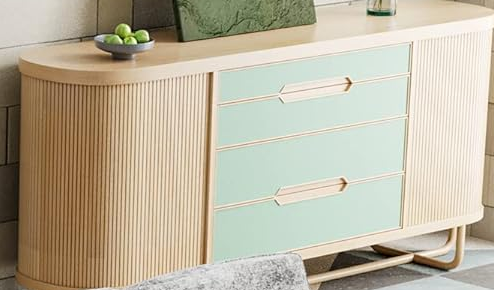

[[0.85490196 0.83529412 0.81176471 ... 0.73333333 0.73333333 0.71764706]]
['Modern']


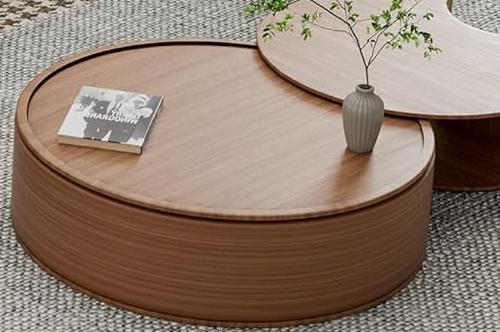

[[0.51764706 0.47058824 0.41568627 ... 0.61176471 0.60784314 0.58431373]]
['Modern']


In [80]:
# 크롭별 스타일
for obj in crop_img['objects']:
    display(obj['crop_img'])
    crop_processing = process_image_file(obj['crop_img'])
    print(crop_processing)
    crop_predict = model.predict(crop_processing)
    crop_style = le.inverse_transform(crop_predict)
    print(crop_style)

In [15]:
# input img, output Style string
def Style_Classificator(img):
    

SyntaxError: unexpected EOF while parsing (725270243.py, line 3)